In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']
missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%', 'FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']



#setup y
y_cols = ['Ever Enrolled Count']


    
x_cols = []
for col in df.columns:
    if col not in y_cols and col not in keys and col not in missing_cols: 
        x_cols.append(col)  

        
y = df[y_cols]
X = df[x_cols]

X = X/X.std()

In [3]:
training_test = []
num_trials = 5
for i in range(num_trials):
    test_size = 0.33
    np.random.seed()
    X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), y, test_size=test_size)
    training_test.append( (X_train, X_test, y_train, y_test) )

In [4]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_pred < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

0.8412870554281437
0.8167463469682598
0.5842956631538558
1.1459759743552167
2.7680259972749277


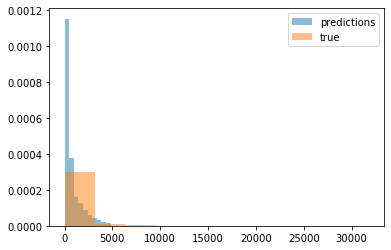

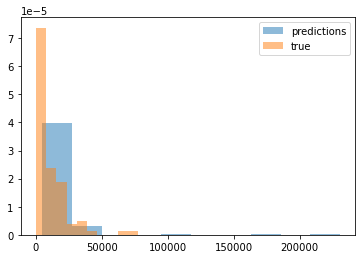

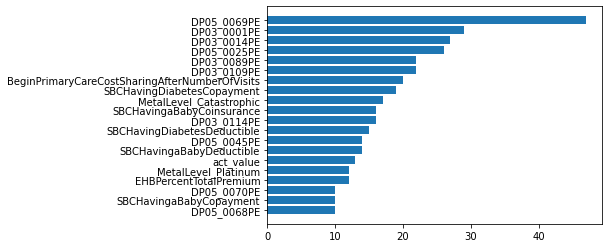

32121373.88577009 -0.23126620743608078
24953221.86747664 0.15871294457185625
0.8460056348381426
0.7759762800679361
0.5186579080662497
1.4958057659100836
1.362994579258368


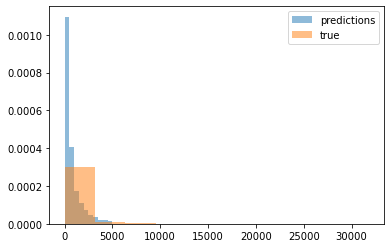

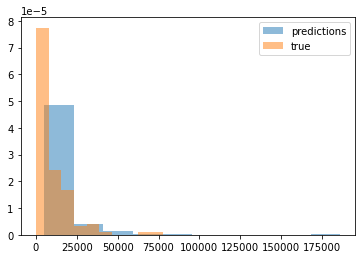

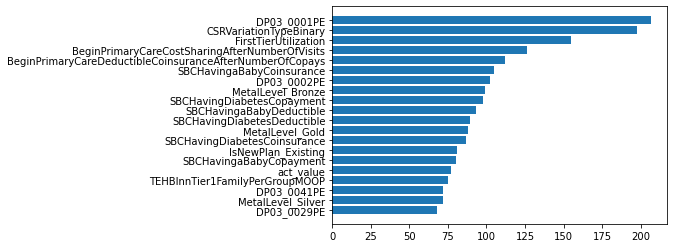

28604281.217445444 0.00011196637184400782
23707615.40876152 0.15399436516185738


In [5]:
params = [(2,.5,.9,.9),(5,.5, 0.5, .9)]


for param in params:
    mses = []
    r2s = []
    for i in range(num_trials):
        X_train, X_test, y_train, y_test = training_test[i]
        # not super deep, but uses most of the data at one
        model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=param[0],
                             eta=param[1], subsample=param[2], colsample_bytree=param[3])
        model.fit(X_train, y_train)

        y_pred = get_predictions(model,X_test)
        mse = float( ((y_test - y_pred)**2).mean() )
        r2 = float(  1- mse/y_test.var() ) 
        print(float(mse/y_test.var()))
        mses.append(mse)
        r2s.append(r2)

        #plot the difference between true and predicted
        if i == num_trials -1:
            split = 5000
            plot_prediction(split,y_pred,y_test)
            plot_importance(X_test,model)

    print( np.array(mses).mean() , np.array(r2s).mean()  )
    print( np.median(mses) , np.median(r2s)  )

0.8042739375588126
0.7465171564491857
0.5277235599270561
0.8488600958550674
0.727866341686727


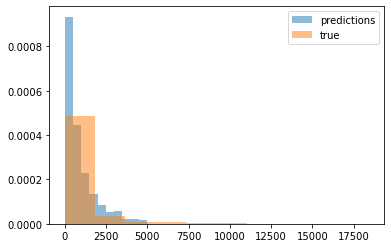

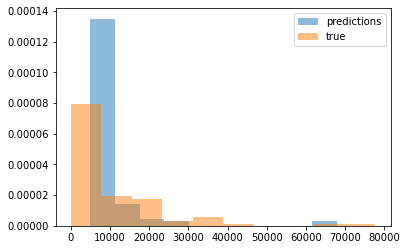

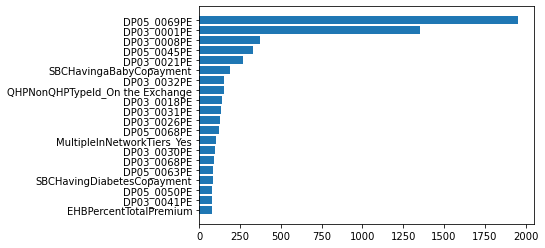

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     23281.870576          3480.000000           NaN           NaN
FL     20404.093176         21033.454545  23792.238416  11293.216170
TX     14735.343460         19894.181818   6942.130454  27217.034459
MI      9564.542394          1899.000000    257.380515    606.697618
GA      7971.719535         12794.000000    843.017336  10802.720537
OH      7648.552284           339.000000           NaN           NaN
LA      6642.185775         15019.000000           NaN           NaN
PA      6487.964289         26033.333333   1274.853197   7840.630226
MO      6081.645430         16366.000000           NaN           NaN
KS      5707.227985         21037.000000           NaN           NaN
VA      5324.901340         17539.500000   3007.581356  10112.918817
OR      5113.371542         17144.000000   2598.910623   9547.355760
OK      5023.485810         25732.

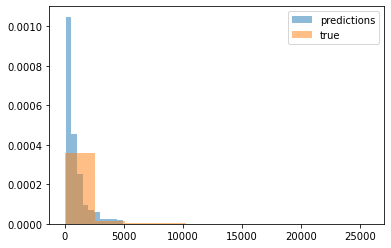

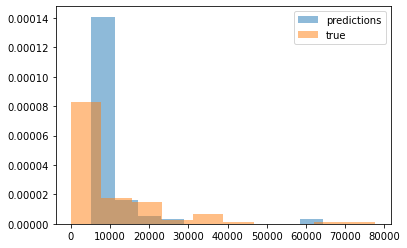

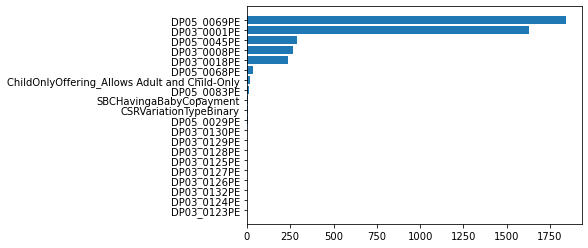

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     22776.500478          3480.000000           NaN           NaN
FL     18926.274867         21033.454545  22847.967208  11293.216170
TX     14603.962596         21863.700000   6733.678715  27850.751919
NJ      9828.828996           928.000000           NaN           NaN
MI      9768.423458          1899.000000     13.482836    606.697618
OH      7477.219823           339.000000           NaN           NaN
GA      7004.566035         18898.500000    662.051663   3131.775934
PA      5802.831737         26033.333333   1690.133080   7840.630226
LA      5734.305961         15019.000000           NaN           NaN
OR      4910.364546         17144.000000   2758.113539   9547.355760
VA      4883.883558         17539.500000   3138.014516  10112.918817
MO      4538.232239         16366.000000           NaN           NaN
KS      3956.543887         21037.

In [8]:
# Vary alpha values
a = [100,250]

for i in a: 
    mses = []
    r2s = []
    for j in range(num_trials):
        X_train, X_test, y_train, y_test = training_test[j]
        
        lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
        y_pred = get_predictions(lasso,X_test)

        mse = float(((y_test - y_pred)**2).mean())
        r2 = float( 1 - mse/y_test.var() )
        print(float(mse/y_test.var()))
        mses.append(mse)
        r2s.append(r2)
        

        if j == num_trials -1:
            #plot the difference between true and predicted
            split = 5000
            plot_prediction(split,y_pred,y_test)

            #also plot important feature
            param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
            param_df['features'] = param_df.index
            plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
            plt.show()
            print(report_error(y_test,y_pred))

    print('alpha_value:', i)
    print( np.array(mses).mean() , np.array(r2s).mean()  )
    print( np.median(mses) , np.median(r2s)  )
    print('==========================================')
    print('==========================================')

In [7]:
#some training sets total number of consumers?
#some times DP03_CSR?